  0%|          | 0/50 [00:00<?, ?it/s]

Valid Loss: 0.3088, Valid Accuracy: 91.0714%


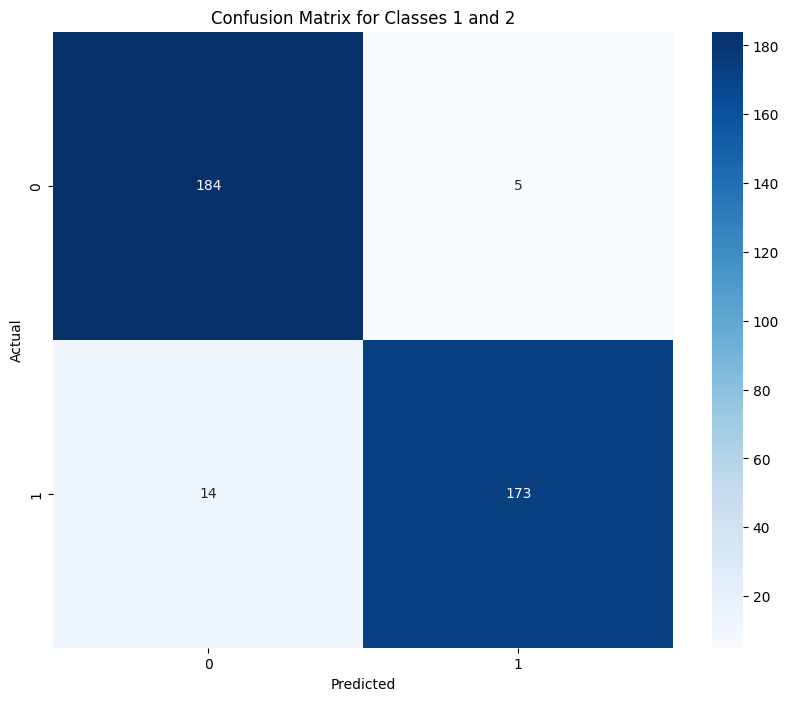

Classification Report for Classes 1 and 2:
               precision    recall  f1-score   support

           1       0.93      0.92      0.93       199
           2       0.97      0.90      0.93       193

   micro avg       0.95      0.91      0.93       392
   macro avg       0.95      0.91      0.93       392
weighted avg       0.95      0.91      0.93       392



In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm.auto import tqdm

from arwa.CONFIG import Config

config = Config()

# ==========================================================================
# Hyper-parameters
# ==========================================================================
DEVICE = config.DEVICE
IMG_SIZE = config.IMG_SIZE
BATCH_SIZE = config.BATCH_SIZE
NUM_EPOCHS = config.NUM_EPOCHS
LEARNING_RATE = config.LEARNING_RATE
WEIGHT_DECAY = config.WEIGHT_DECAY

# ==========================================================================
# Dataset
# ==========================================================================
class myDataset(Dataset):
    def __init__(self, data_folder="./boxes_v2", dataset_file="./boxes_v2.txt", transform=None):
        self.transform = transform
        f = open(dataset_file, "r")
        self.class_index_list = []
        self.image_path_list = []
        for line in f.readlines():
            class_index, file_name = [x.strip() for x in line.split(" ")]
            image_path = os.path.join(data_folder, file_name)
            self.class_index_list.append(int(class_index))
            self.image_path_list.append(image_path)
        f.close()

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, index):
        label = self.class_index_list[index]
        image_path = self.image_path_list[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        return image, label

# ==========================================================================
# Dataloader
# ==========================================================================
class myDataloader:
    def __init__(self, batch_size=128, random_seed=42, valid_size=0.2, shuffle=True, num_test_samples=400):
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.valid_size = valid_size
        self.shuffle = shuffle
        self.num_test_samples = num_test_samples

    def load_data(self):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        train_tranform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

        valid_tranform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

        train_dataset = myDataset(transform=train_tranform)
        valid_dataset = myDataset(transform=valid_tranform)

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(self.valid_size * num_train))

        if self.shuffle:
            np.random.seed(self.random_seed)
            np.random.seed(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)

        # Échantillonnage aléatoire de 400 images pour le test
        test_indices = np.random.choice(valid_idx, size=self.num_test_samples, replace=False)
        valid_sampler = SubsetRandomSampler(test_indices)

        train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_size, sampler=train_sampler)

        valid_loader = DataLoader(dataset=valid_dataset, batch_size=self.batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)

# ==========================================================================
# Test function
# ==========================================================================
def test_phase(test_loader, model, criterion):
    n_iterations = len(test_loader)
    size = 0
    test_loss = 0
    test_accuracy = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, total=n_iterations):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            size += labels.size(0)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            y_hat = F.softmax(outputs, dim=1)
            _, index_softmax = torch.max(y_hat.data, dim=1)

            # Filtrer les classes 0 (background)
            mask = labels != 0
            filtered_labels = labels[mask]
            filtered_preds = index_softmax[mask]

            test_accuracy += (filtered_preds == filtered_labels).sum().item()

            all_labels.extend(filtered_labels.cpu().numpy())
            all_preds.extend(filtered_preds.cpu().numpy())

            del images, labels

    test_loss /= n_iterations
    test_accuracy /= len(all_labels)  # Diviser par la taille des labels filtrés

    return test_loss, test_accuracy * 100, all_labels, all_preds

# ==========================================================================
# Define model
# ==========================================================================
model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=512, out_features=128, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=config.NUM_CLASSES, bias=True),
)

model.to(DEVICE)

# ==========================================================================
# Loss function and Optimizer
# ==========================================================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.load_state_dict(torch.load("./best0.pt"))
model.to(config.DEVICE)
model.eval()

# Training + Validation
dataloader = myDataloader(batch_size=BATCH_SIZE, num_test_samples=400)  # Limite à 400 images
train_loader, test_loader = dataloader.load_data()

test_loss, test_accuracy, all_labels, all_preds = test_phase(test_loader=test_loader, model=model, criterion=criterion)

print("Valid Loss: {:.4f}, Valid Accuracy: {:.4f}%".format(test_loss, test_accuracy))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds, labels=[1, 2])  # Spécifier les classes 1 et 2
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classes 1 and 2')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, labels=[1, 2])
print("Classification Report for Classes 1 and 2:\n", class_report)
